In [20]:
#!/usr/bin/env python3
"""
Kaggle Notebook Version: SHERLOCK-style (Self-Supervised ViT with Masked Autoencoder)
for Malimg Family Classification (25 classes).

Pipeline:
1. Load Malimg dataset (organized as /kaggle/input/malimg-dataset/Malimg/<family_name>/...)
2. Convert grayscale to RGB (3 channels).
3. Stratified split → train / val / test.
4. Self-supervised pretraining with MAE (ViT encoder).
5. Fine-tuning classifier for 25 family classes.
6. Evaluation: AUC-ROC, confusion matrix, t-SNE.

Outputs saved under /kaggle/working/malimg_run1/:
- mae_encoder.pt (encoder weights)
- best_model.pt (fine-tuned classifier)
- metrics.json (macro AUC + classification report)
- confusion_matrix.png
- tsne.png
"""

# ------------------------------
# User Config (Kaggle)
# ------------------------------
DATA_ROOT = "/kaggle/input/malimg-original/malimg_paper_dataset_imgs"   # dataset path
OUTPUT_DIR = "/kaggle/working/malimg_run1"          # save outputs here

IMG_SIZE = 224
BATCH_SIZE = 128
MAE_EPOCHS = 100   # self-supervised pretraining epochs
FT_EPOCHS = 100    # fine-tuning epochs
LR_MAE = 1e-4
LR_FT = 1e-4
SEED = 42

In [21]:
# ------------------------------
# Imports
# ------------------------------
import os, json, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import timm

In [22]:
# ------------------------------
# Utilities
# ------------------------------
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [23]:
# ------------------------------
# Dataset
# ------------------------------
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp")

def find_images(root: str):
    root = Path(root)
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    class_to_idx = {c: i for i, c in enumerate(classes)}
    paths, labels = [], []
    for c in classes:
        for p in (root / c).rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                paths.append(str(p))
                labels.append(class_to_idx[c])
    return paths, labels, classes

class MalimgDataset(Dataset):
    def __init__(self, paths, labels, img_size=224):
        self.paths = paths
        self.labels = labels
        self.tfm = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.Lambda(lambda im: im.convert('RGB')),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]
        im = Image.open(p).convert('L')
        x = self.tfm(im)
        return x, y

In [24]:
# ------------------------------
# MAE components
# ------------------------------
class PatchMasker:
    def __init__(self, mask_ratio=0.75):
        self.mask_ratio = mask_ratio
    def __call__(self, x):
        B, N, D = x.shape
        len_keep = int(N * (1 - self.mask_ratio))
        noise = torch.rand(B, N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]
        x_keep = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))
        mask = torch.ones([B, N], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, 1, ids_restore)
        return x_keep, ids_restore, mask
class MAEDecoder(nn.Module):
    def __init__(self, embed_dim=768, decoder_dim=512, patch_dim=768, depth=4, num_heads=8):
        super().__init__()
        self.enc2dec = nn.Linear(embed_dim, decoder_dim, bias=False)
        layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=num_heads, batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=depth)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        self.pred = nn.Linear(decoder_dim, patch_dim)
        nn.init.normal_(self.mask_token, std=0.02)
    def forward(self, x_vis, ids_restore):
        B, _, D_enc = x_vis.shape
        x = self.enc2dec(x_vis)
        B, N, D_dec = ids_restore.shape[0], ids_restore.shape[1], x.shape[-1]
        mask_tokens = self.mask_token.repeat(B, N - x.shape[1], 1)
        x_ = torch.cat([x, mask_tokens], dim=1)
        x_ = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, D_dec))
        x_ = self.tr(x_)
        pred = self.pred(x_)
        return pred
class MAE(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=768, mask_ratio=0.75):
        super().__init__()
        self.encoder = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=0, img_size=img_size)
        self.patch_embed = self.encoder.patch_embed
        self.cls_token = self.encoder.cls_token
        self.pos_embed = self.encoder.pos_embed
        self.blocks = self.encoder.blocks
        self.norm = self.encoder.norm
        self.masker = PatchMasker(mask_ratio)
        self.decoder = MAEDecoder(embed_dim=embed_dim, decoder_dim=512, patch_dim=embed_dim)
    def forward(self, x):
        # patch embedding: [B, num_patches, embed_dim]
        x = self.patch_embed(x)          # already flattened
        B, N, D = x.shape                # batch, num_patches, embedding_dim
    
        # masking
        x_vis, ids_restore, mask = self.masker(x)
    
        # add class token + positional embeddings
        cls_tok = self.cls_token.expand(B, -1, -1)
        pos = self.pos_embed[:, 1:, :]   # remove cls pos
        pos_vis, _, _ = self.masker(pos.expand(B, -1, -1))
    
        x_enc = torch.cat([cls_tok, x_vis + pos_vis], 1)
        for blk in self.blocks:
            x_enc = blk(x_enc)
        x_enc = self.norm(x_enc)
    
        x_enc_patches = x_enc[:, 1:, :]   # drop CLS token
    
        # reconstruct
        pred = self.decoder(x_enc_patches, ids_restore)
    
        # loss
        loss = (pred - x).pow(2).mean(-1)
        loss = (loss * mask).sum() / mask.sum()
        return loss

    def encoder_only(self): return self.encoder

In [25]:
# ------------------------------
# Classifier
# ------------------------------
class ViTClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(self.encoder.num_features, num_classes)
    def forward(self, x):
        feats = self.encoder(x)
        logits = self.head(feats)
        return logits, feats

In [26]:
# ------------------------------
# Train functions
# ------------------------------
def train_mae(model, loader, epochs, device, lr=1e-4):
    model.train(); opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    for ep in range(epochs):
        total = 0.0
        for x, _ in loader:
            x = x.to(device)
            loss = model(x)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item() * x.size(0)
        print(f"[MAE] Epoch {ep+1}/{epochs}  loss={total/len(loader.dataset):.4f}")

def train_finetune(model, train_loader, val_loader, epochs, device, lr=1e-4):
    criterion = nn.CrossEntropyLoss(); opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    best_acc, best_state = 0.0, None
    for ep in range(epochs):
        model.train(); correct=total=0
        for x, y in train_loader:
            x,y=x.to(device),torch.tensor(y,device=device)
            logits,_=model(x)
            loss=criterion(logits,y)
            opt.zero_grad();loss.backward();opt.step()
            pred=logits.argmax(1);correct+=(pred==y).sum().item();total+=y.size(0)
        train_acc=correct/total
        model.eval(); v_correct=v_total=0
        with torch.no_grad():
            for x,y in val_loader:
                x,y=x.to(device),torch.tensor(y,device=device)
                logits,_=model(x);pred=logits.argmax(1)
                v_correct+=(pred==y).sum().item();v_total+=y.size(0)
        val_acc=v_correct/v_total
        print(f"[FT] Epoch {ep+1}/{epochs}  train_acc={train_acc:.4f}  val_acc={val_acc:.4f}")
        if val_acc>best_acc: best_acc=val_acc;best_state={k:v.cpu() for k,v in model.state_dict().items()}
    if best_state: model.load_state_dict(best_state)
    return model,best_acc

In [27]:
def evaluate(model, loader, device, num_classes, class_names, out_dir:Path):
    model.eval(); all_logits, all_labels, all_feats=[],[],[]
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device);logits,feats=model(x)
            all_logits.append(logits.cpu());all_labels.append(torch.tensor(y));all_feats.append(feats.cpu())
    logits=torch.cat(all_logits,0);labels=torch.cat(all_labels,0);feats=torch.cat(all_feats,0)
    probs=F.softmax(logits,1).numpy();y_true=labels.numpy()
    y_onehot=np.zeros((y_true.size,num_classes));y_onehot[np.arange(y_true.size),y_true]=1
    auc_macro=roc_auc_score(y_onehot,probs,average='macro',multi_class='ovr')
    
    # === Print AUC-ROC ===
    print("Macro AUC (OvR):", auc_macro)
    from sklearn.metrics import roc_curve, auc

    # === ROC Curves per Class ===
    plt.figure(figsize=(10,8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_onehot[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1.5, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
    
    plt.plot([0,1], [0,1], 'k--', lw=1)  # diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (per class)")
    plt.legend(loc="lower right", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


    # === Confusion Matrix with Seaborn ===
    cm=confusion_matrix(y_true,probs.argmax(1))
    plt.figure(figsize=(18,16))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names,
        cbar=True
    )
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    from matplotlib.lines import Line2D
    import matplotlib.cm as cm
    
    # === t-SNE Visualization with all Families ===
    tsne = TSNE(n_components=2, random_state=42).fit_transform(feats.numpy())
    plt.figure(figsize=(12,10))
    
    # use tab20 colormap (repeats if >20 classes)
    colors = cm.get_cmap('tab20', num_classes)
    
    # plot each family separately so legend is accurate
    for i in range(num_classes):
        idx = (y_true == i)
        plt.scatter(tsne[idx,0], tsne[idx,1], 
                    s=12, color=colors(i), label=class_names[i], alpha=0.7)
    
    plt.title("t-SNE Visualization by Family")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()



    # === Classification Report + Metrics JSON ===
    report=classification_report(y_true,probs.argmax(1),target_names=class_names,digits=4,zero_division=0)
    metrics={'auc_macro_ovr':float(auc_macro),'num_classes':num_classes,'samples':int(y_true.size),'classification_report':report}
    with open(out_dir/'metrics.json','w') as f:json.dump(metrics,f,indent=2)
    print("\n=== Classification Report ===\n")
    print(report)
    print("Evaluation complete. Metrics saved.")


Device: cuda
[MAE] Epoch 1/5  loss=0.0923
[MAE] Epoch 2/5  loss=0.0235
[MAE] Epoch 3/5  loss=0.0088
[MAE] Epoch 4/5  loss=0.0035
[MAE] Epoch 5/5  loss=0.0014


/tmp/ipykernel_36/2706796268.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y,device=device)
/tmp/ipykernel_36/2706796268.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x,y=x.to(device),torch.tensor(y,device=device)


[FT] Epoch 1/5  train_acc=0.7340  val_acc=0.9143
[FT] Epoch 2/5  train_acc=0.9328  val_acc=0.9350
[FT] Epoch 3/5  train_acc=0.9503  val_acc=0.9400
[FT] Epoch 4/5  train_acc=0.9628  val_acc=0.9550
[FT] Epoch 5/5  train_acc=0.9615  val_acc=0.9279


/tmp/ipykernel_36/2629978503.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_logits.append(logits.cpu());all_labels.append(torch.tensor(y));all_feats.append(feats.cpu())


Macro AUC (OvR): 0.9993459645044647


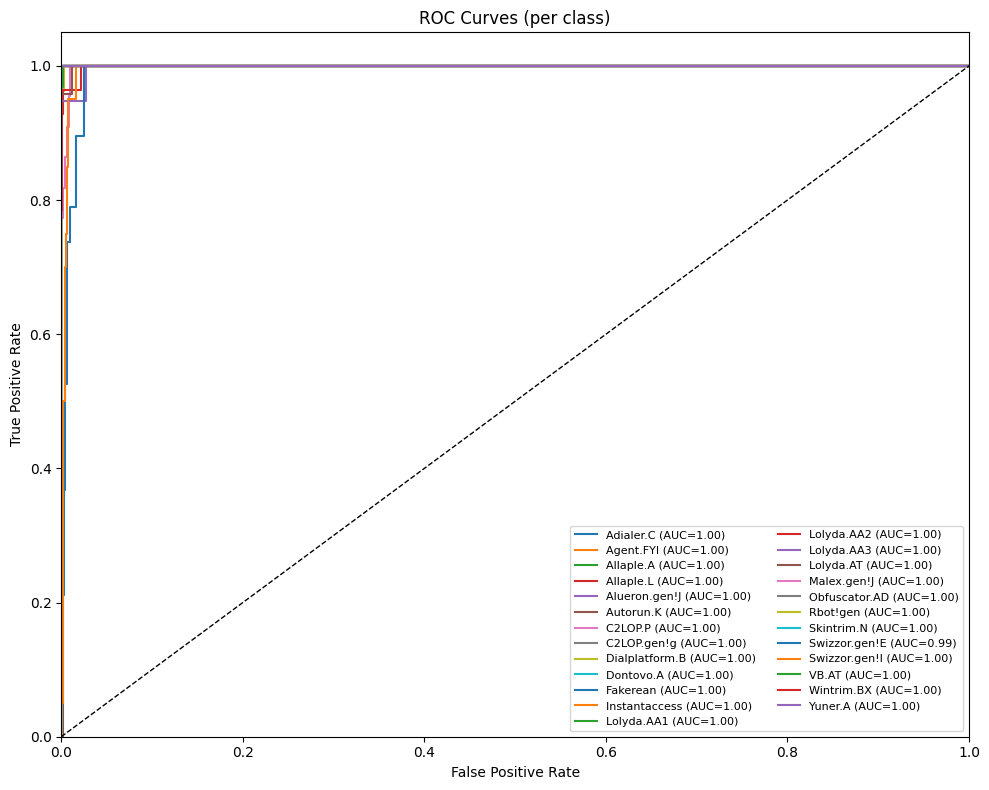

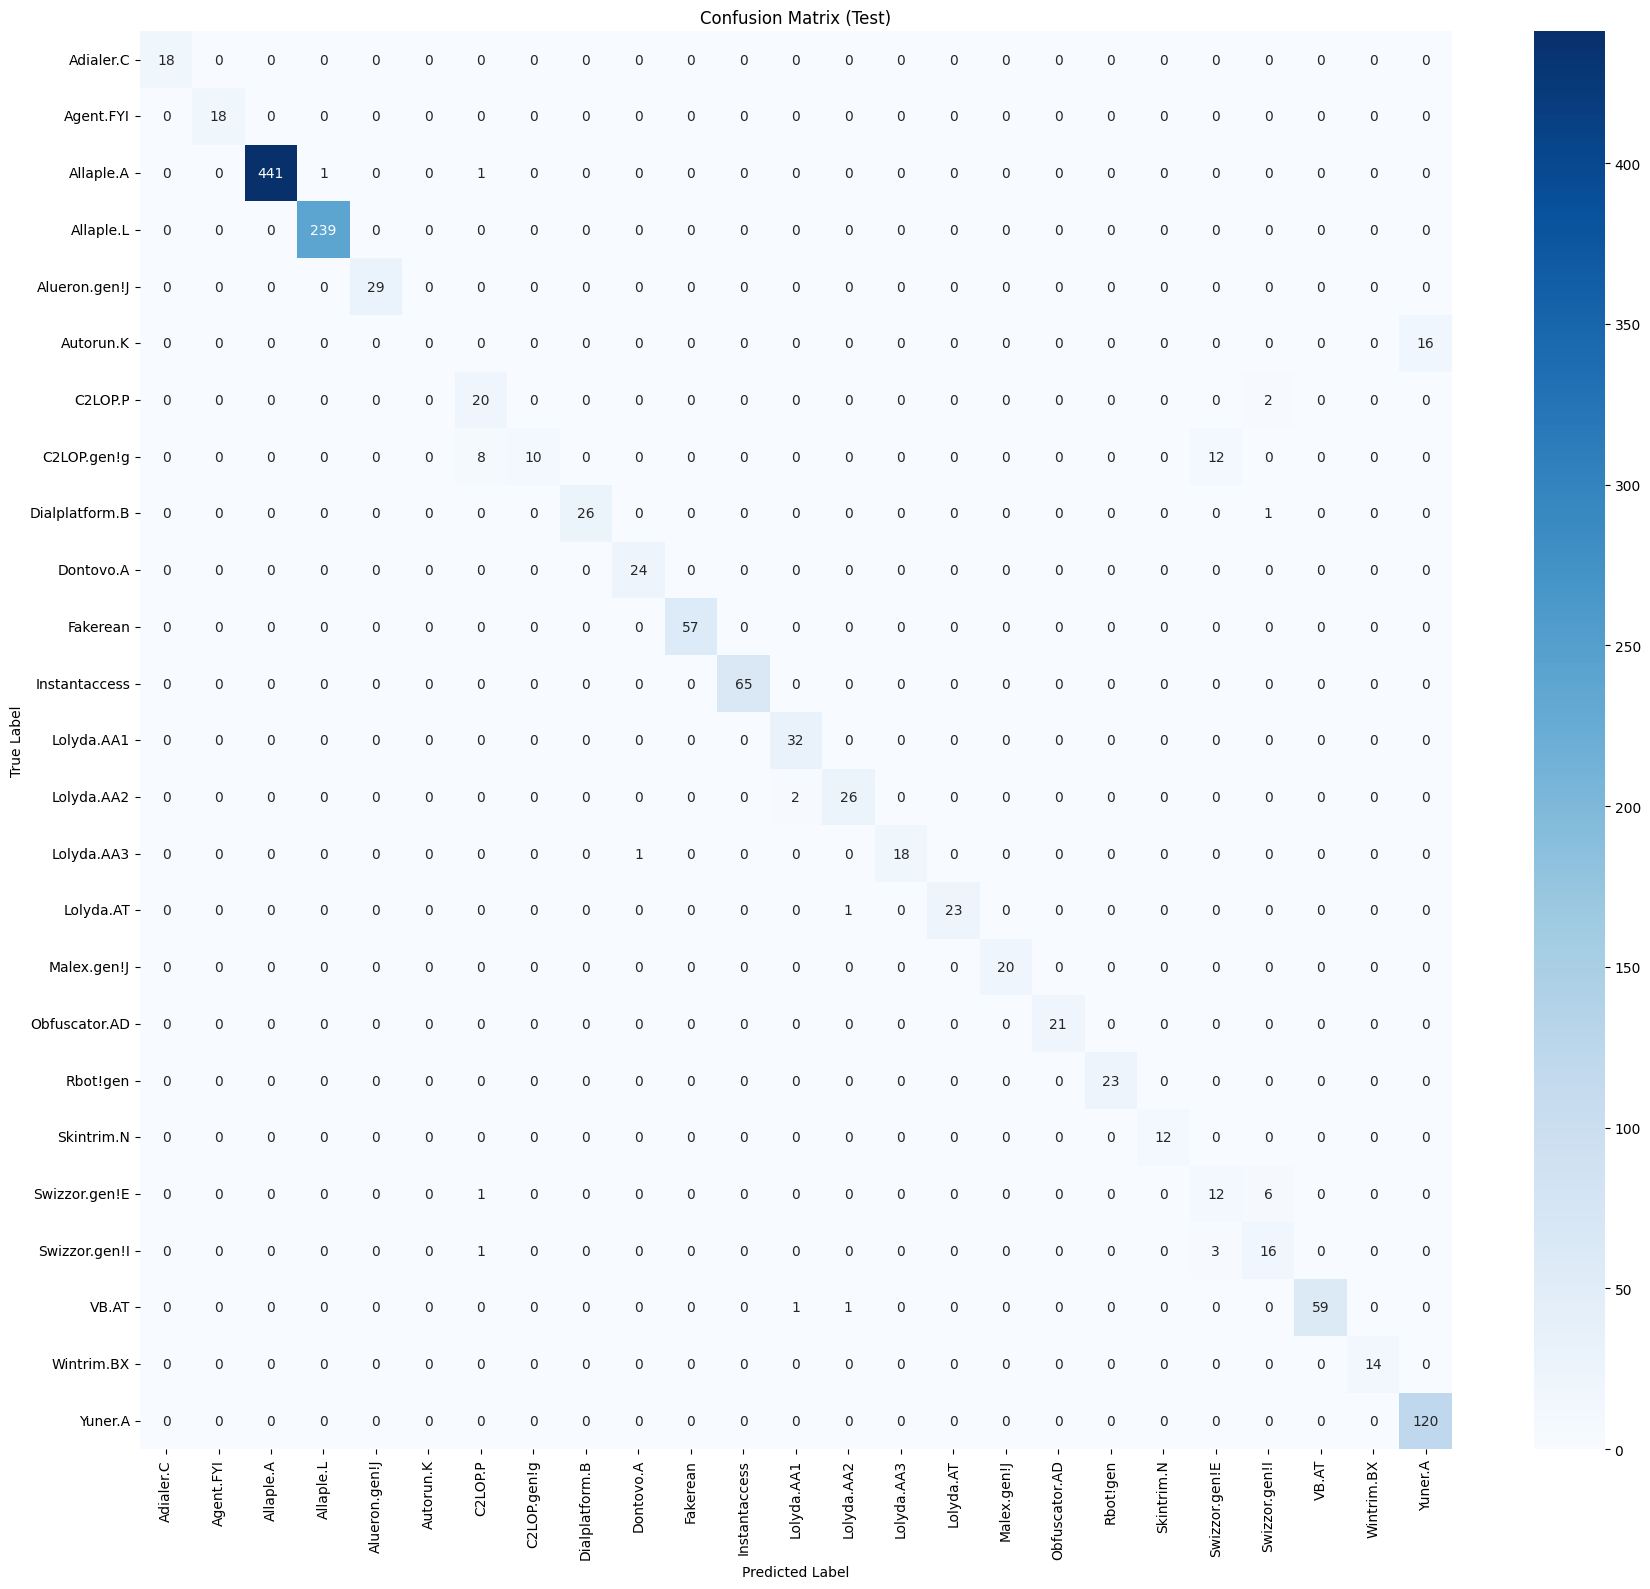

/tmp/ipykernel_36/2629978503.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', num_classes)


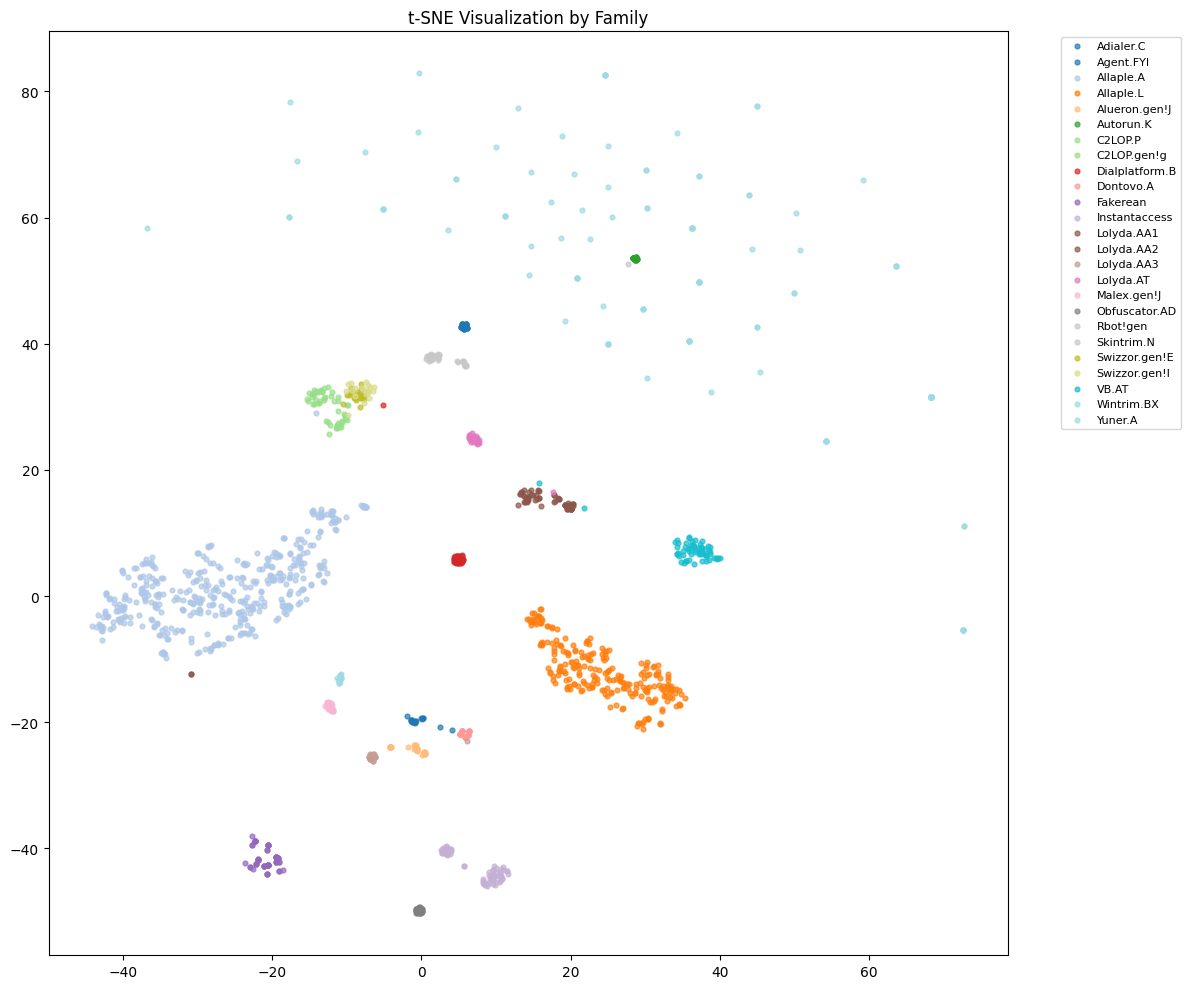


=== Classification Report ===

                precision    recall  f1-score   support

     Adialer.C     1.0000    1.0000    1.0000        18
     Agent.FYI     1.0000    1.0000    1.0000        18
     Allaple.A     1.0000    0.9955    0.9977       443
     Allaple.L     0.9958    1.0000    0.9979       239
 Alueron.gen!J     1.0000    1.0000    1.0000        29
     Autorun.K     0.0000    0.0000    0.0000        16
       C2LOP.P     0.6452    0.9091    0.7547        22
   C2LOP.gen!g     1.0000    0.3333    0.5000        30
Dialplatform.B     1.0000    0.9630    0.9811        27
     Dontovo.A     0.9600    1.0000    0.9796        24
      Fakerean     1.0000    1.0000    1.0000        57
 Instantaccess     1.0000    1.0000    1.0000        65
    Lolyda.AA1     0.9143    1.0000    0.9552        32
    Lolyda.AA2     0.9286    0.9286    0.9286        28
    Lolyda.AA3     1.0000    0.9474    0.9730        19
     Lolyda.AT     1.0000    0.9583    0.9787        24
   Malex.gen!J 

In [28]:

# ------------------------------
# Main for Kaggle
# ------------------------------
def stratified_split(paths, labels, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    sss1=StratifiedShuffleSplit(n_splits=1,test_size=(1-train_size),random_state=seed)
    idx=np.arange(len(paths));train_idx,temp_idx=next(sss1.split(idx,labels))
    temp_labels=np.array(labels)[temp_idx]
    sss2=StratifiedShuffleSplit(n_splits=1,test_size=test_size/(val_size+test_size),random_state=seed)
    val_idx_rel,test_idx_rel=next(sss2.split(temp_idx,temp_labels))
    return train_idx,temp_idx[val_idx_rel],temp_idx[test_idx_rel]

def main_kaggle():
    seed_everything(SEED)
    out_dir=Path(OUTPUT_DIR);out_dir.mkdir(parents=True,exist_ok=True)
    device='cuda' if torch.cuda.is_available() else 'cpu';print('Device:',device)
    paths,labels,classes=find_images(DATA_ROOT)
    train_idx,val_idx,test_idx=stratified_split(paths,labels,0.7,0.15,0.15,SEED)
    def subset(lst,idx): return [lst[i] for i in idx]
    train_set=MalimgDataset(subset(paths,train_idx),subset(labels,train_idx),IMG_SIZE)
    val_set=MalimgDataset(subset(paths,val_idx),subset(labels,val_idx),IMG_SIZE)
    test_set=MalimgDataset(subset(paths,test_idx),subset(labels,test_idx),IMG_SIZE)
    train_loader_mae=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
    train_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
    val_loader=DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
    test_loader=DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)
    mae=MAE(img_size=IMG_SIZE,patch_size=16,embed_dim=768,mask_ratio=0.75).to(device)
    if MAE_EPOCHS>0:
        train_mae(mae,train_loader_mae,MAE_EPOCHS,device,LR_MAE)
        torch.save(mae.encoder.state_dict(),out_dir/'mae_encoder.pt')
    encoder=mae.encoder;model=ViTClassifier(encoder,num_classes=len(classes)).to(device)
    model,_=train_finetune(model,train_loader,val_loader,FT_EPOCHS,device,LR_FT)
    torch.save(model.state_dict(),out_dir/'best_model.pt')
    evaluate(model,test_loader,device,len(classes),classes,out_dir)

# Run in Kaggle Notebook:
main_kaggle()
